In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
import regression as reg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR 
from IPython.display import display

In [3]:
df = pd.read_csv('data/cleaned_cars.csv')
df = pd.get_dummies(df, columns = ['country'], drop_first=True, dtype=np.int8)
df.head()

,engine_capacity,cylinder,horse_power,top_speed,seats,brand,price,year,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,2.0,4,180,205.0,8,peugeot,37955.250,2021,0,1,0,0,0,0
1,1.5,4,102,145.0,4,suzuki,26671.950,2021,0,1,0,0,0,0
2,2.3,4,420,173.0,4,ford,53460.000,2021,0,1,0,0,0,0
3,1.8,4,140,190.0,5,honda,28179.975,2021,0,1,0,0,0,0
4,1.8,4,140,190.0,5,honda,25740.450,2021,0,1,0,0,0,0


## Target encoding

In [4]:
X = df.copy()
y = X.pop('price')

X_encode = X.sample(frac=0.2, random_state=42)
y_encode = y[X_encode.index]
X = X.drop(X_encode.index)
y = y[X.index]

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["brand"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X = encoder.transform(X)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)  

X.head()

,engine_capacity,cylinder,horse_power,top_speed,seats,brand,year,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,2.0,4,180,205.0,8,32078.069442,2021,0,1,0,0,0,0
1,1.5,4,102,145.0,4,28438.222866,2021,0,1,0,0,0,0
2,2.3,4,420,173.0,4,43785.523914,2021,0,1,0,0,0,0
3,1.8,4,140,190.0,5,33980.315600,2021,0,1,0,0,0,0
4,1.8,4,140,190.0,5,33980.315600,2021,0,1,0,0,0,0


In [5]:
X.head()

,engine_capacity,cylinder,horse_power,top_speed,seats,brand,year,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,2.0,4,180,205.0,8,32078.069442,2021,0,1,0,0,0,0
1,1.5,4,102,145.0,4,28438.222866,2021,0,1,0,0,0,0
2,2.3,4,420,173.0,4,43785.523914,2021,0,1,0,0,0,0
3,1.8,4,140,190.0,5,33980.315600,2021,0,1,0,0,0,0
4,1.8,4,140,190.0,5,33980.315600,2021,0,1,0,0,0,0


In [6]:
y.head()

0    37955.250
1    26671.950
2    53460.000
3    28179.975
4    25740.450
Name: price, dtype: float64

In [7]:
# Split the dataset into training (60%) and temporary (40%) sets with a fixed random_state
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into validation (50% of temporary, i.e., 20% of total) and test (50% of temporary, i.e., 20% of total) sets with the same random_state
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_scaled.head()

,engine_capacity,cylinder,horse_power,top_speed,seats,brand,year,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,0.275,0.3125,0.016650,0.456366,0.1875,0.054810,0.928571,0.0,0.0,0.0,0.0,1.0,0.0
1,0.250,0.3125,0.029288,0.656652,0.1875,0.225332,0.928571,0.0,0.0,0.0,0.0,0.0,1.0
2,0.250,0.2500,0.031896,0.570815,0.1875,0.097633,0.928571,0.0,0.0,1.0,0.0,0.0,0.0
3,0.175,0.2500,0.007021,0.490701,0.1250,0.023318,0.928571,0.0,0.0,0.0,0.0,1.0,0.0
4,0.375,0.3750,0.057172,0.688126,0.1875,0.283739,0.928571,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# scaler = MinMaxScaler()
# columns_to_scale = [col for col in X_train.columns if col != 'brand']
# X_train_scaled = X_train[columns_to_scale]
# X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
# X_train_scaled = pd.concat([X_train_scaled, X_train[['brand']]], axis=1)
# X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
# X_val_scaled = pd.concat([X_val[columns_to_scale], X_val[['brand']]], axis=1)
# X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
# X_test_scaled = pd.concat([X_test[columns_to_scale], X_test[['brand']]], axis=1)

In [11]:
# Print the sizes of the resulting datasets
print(f"Training set size: {(X_train_scaled.shape[0])}")
print(f"Validation set size: {(X_val_scaled.shape[0])}")
print(f"Test set size: {(X_test_scaled.shape[0])}")

# Optionally, print the datasets
print("\nTraining Set:")
X_train_scaled
df_ok = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_ok.head()    

Training set size: 2935
Validation set size: 979
Test set size: 979

Training Set:


,engine_capacity,cylinder,horse_power,top_speed,seats,brand,year,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,0.275,0.3125,0.016650,0.456366,0.1875,0.054810,0.928571,0.0,0.0,0.0,0.0,1.0,0.0
1,0.250,0.3125,0.029288,0.656652,0.1875,0.225332,0.928571,0.0,0.0,0.0,0.0,0.0,1.0
2,0.250,0.2500,0.031896,0.570815,0.1875,0.097633,0.928571,0.0,0.0,1.0,0.0,0.0,0.0
3,0.175,0.2500,0.007021,0.490701,0.1250,0.023318,0.928571,0.0,0.0,0.0,0.0,1.0,0.0
4,0.375,0.3750,0.057172,0.688126,0.1875,0.283739,0.928571,0.0,0.0,0.0,0.0,0.0,0.0


## No API part

In [12]:
w = reg.linear_regression_fit(X_train_scaled, y_train)
y_predict = reg.linear_regression_predict(X_test_scaled, w)


In [13]:
# Calculate mean squared error
mse = mean_squared_error(y_predict, y_test)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3464737894.1110377


In [14]:
num_iterations = 1000
w, errors = reg.gradient_descent(X_train_scaled, y_train, 0.01, num_iterations)
print(w.shape)
y_predict = reg.linear_regression_predict(X_test_scaled, w)
mean_squared_error(y_predict, y_test)

Iteration 0: Error = 18993761497.99351
Iteration 100: Error = 17104592447.070368
Iteration 200: Error = 15842981894.313168
Iteration 300: Error = 14997916456.288897
Iteration 400: Error = 14429353836.238865
Iteration 500: Error = 14044352614.417812
Iteration 600: Error = 13781230478.117664
Iteration 700: Error = 13599050628.336563
Iteration 800: Error = 13470644299.003654
Iteration 900: Error = 13377980062.514406
(14,)


np.float64(8204837356.548652)

/tmp/ipykernel_39310/2113387963.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


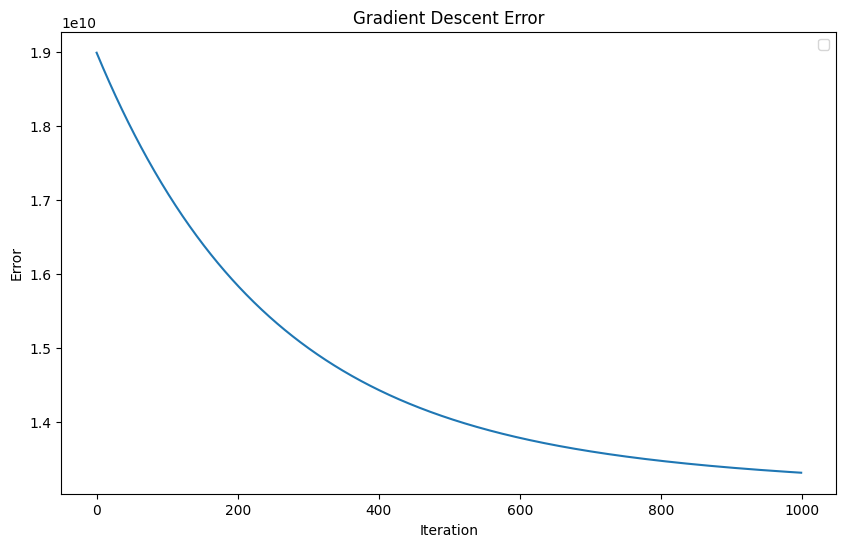

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()

In [16]:
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Lasso Implementation(API)

In [17]:
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)
y_train_pred = lasso.predict(X_train_scaled)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train,y_train_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 26519.699745017835
Mean Squared Error: 7944848930.17672
R2 Score: 0.4297581448404999


In [18]:
y_val_pred = lasso.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val,y_val_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 24940.53357192531
Mean Squared Error: 2311072654.6518354
R2 Score: 0.6851256858639838


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [19]:
# Hyperparamater Values
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

In [20]:
#Using Grid Search to find the optimal value for alpha

lasso_cv = GridSearchCV(lasso,param_grid,cv = 5,n_jobs = -1)
lasso_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [21]:
#Testing Lasso on the validation set
y_val_pred = lasso_cv.predict(X_val_scaled)
mae_lasso_val = mean_absolute_error(y_val, y_val_pred)
mse_lasso_val = mean_squared_error(y_val, y_val_pred)
r2_lasso_val = r2_score(y_val, y_val_pred) 
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 24940.53357192531
Mean Squared Error: 2311072654.6518354
R2 Score: 0.6851256858639838


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [22]:
y_test_pred = lasso_cv.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
results = {
    "Metric": ["Mean Absolute Error", "Mean Squared Error", "R2 Score"],
    "Value": [mae, mse, r2]
}

# Create a DataFrame
results_df = pd.DataFrame(results)

df = pd.DataFrame(results_df).T  # Transpose to get models as rows
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
display(df)

# Convert to LaTeX
latex_table = df.to_latex(index=False)
print(latex_table)

/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


,Model,0,1,2
0,Metric,Mean Absolute Error,Mean Squared Error,R2 Score
1,Value,24694.988254,3560159080.590833,0.592437


\begin{tabular}{llll}
\toprule
Model & 0 & 1 & 2 \\
\midrule
Metric & Mean Absolute Error & Mean Squared Error & R2 Score \\
Value & 24694.988254 & 3560159080.590833 & 0.592437 \\
\bottomrule
\end{tabular}



## Ridge Implementation (API)

In [23]:
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

Ridge()

In [24]:
#Using Grid Search to find the optimal value for alpha

ridge_cv = GridSearchCV(ridge,param_grid,cv = 5,n_jobs = -1)
ridge_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [25]:
#Testing Ridge on the validation set
y_val_pred = ridge_cv.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred) 
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 23496.891405664228
Mean Squared Error: 2345438885.180512
R2 Score: 0.6804434257691417


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [26]:
y_test_pred = ridge_cv.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 22627.583138129015
Mean Squared Error: 5095400185.469961
R2 Score: 0.41668481149504333


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


## Linear Regression

In [27]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
# y_val_pred = lin_model.predict(X_val_scaled)
# mae_lin_val = mean_absolute_error(y_val, y_val_pred)
# mse_lin_val = mean_squared_error(y_val, y_val_pred)
# r2_lin_val = r2_score(y_val, y_val_pred)
# print(f"Mean Absolute Error: {mae}")
# print(f"Mean Squared Error: {mse}")
# print(f"R2 Score: {r2}")

LinearRegression()

In [28]:
y_test_pred = lin_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

    

Mean Absolute Error: 25140.107798234367
Mean Squared Error: 3464737894.1110377
R2 Score: 0.603361038532984


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [29]:
y_val_pred = lin_model.predict(X_val_scaled)


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Polynomial Regression

In [30]:
max_degree = 5
n = len(y_train)
k = X_train_scaled.shape[1]

Degree | MSE         | MAE         | R2         | BIC
--------------------------------------------------
     2 | 2328367984.305641 | 25766.339073 |   0.682769 | 2987.771332
     3 | 10103883733216176077519328378880.000000 | 107856749516403.578125 | -1376613346275684777984.000000 | 43835.122414
     4 | 146823438362082211298302492672.000000 | 19320072117826.363281 | -20004100416443633664.000000 | 176228.432606
     5 | 672166155884506240.000000 | 75242069.983530 | -91579922.674646 | 410714.050952

Results DataFrame:


,Degree,MSE,MAE,R2,BIC
0,2,2.3284e+09,2.5766e+04,6.8277e-01,2.9878e+03
1,3,1.0104e+31,1.0786e+14,-1.3766e+21,4.3835e+04
2,4,1.4682e+29,1.9320e+13,-2.0004e+19,1.7623e+05
3,5,6.7217e+17,7.5242e+07,-9.1580e+07,4.1071e+05


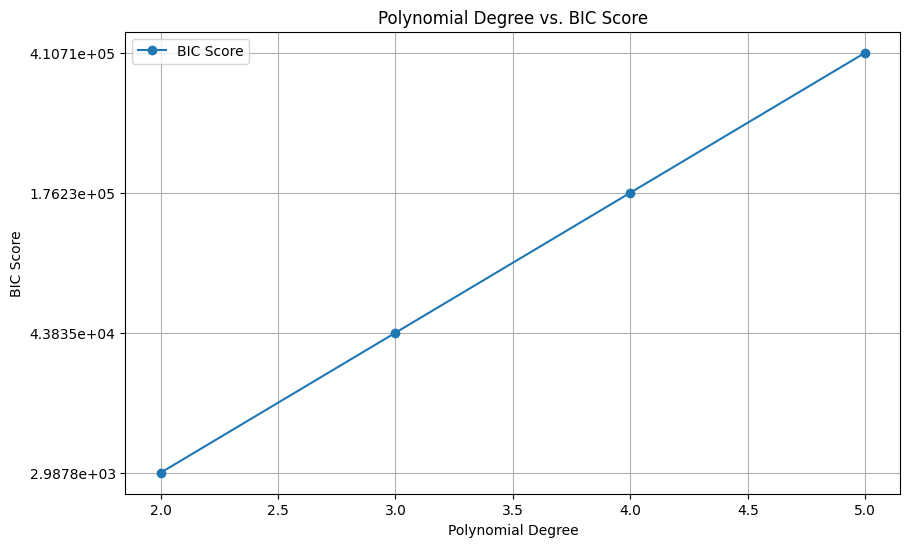

In [31]:
bic_scores = []  # Ensure this list is empty at the start
mse_scores = []
mae_scores = []
r2_scores = []
degrees = range(2, max_degree + 1)

print("Degree | MSE         | MAE         | R2         | BIC")
print("-" * 50)

for degree in degrees:
    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    x_train_poly = poly.fit_transform(X_train_scaled)
    x_val_poly = poly.fit_transform(X_val_scaled)

    # Fit the model
    model = LinearRegression()
    model.fit(x_train_poly, y_train)

    # Predictions
    y_val_pred = model.predict(x_val_poly)

    # Calculate metrics
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    # Calculate RSS and BIC
    rss = np.sum((y_val - y_val_pred) ** 2)
    n = len(y_val)  # Number of samples in validation set
    k = x_val_poly.shape[1]  # Number of parameters (including intercept)
    bic = k * np.log(rss / n) + k * np.log(n)
    # Append the rounded values to the respective lists
    bic_scores.append(f"{bic:.4e}")  # Exponential format
    mse_scores.append(f"{mse:.4e}")
    mae_scores.append(f"{mae:.4e}")
    r2_scores.append(f"{r2:.4e}")

    # Print metrics for the current degree
    print(f"{degree:6} | {mse:10.6f} | {mae:10.6f} | {r2:10.6f} | {bic:10.6f}")

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Degree': degrees,
    'MSE': mse_scores,
    'MAE': mae_scores,
    'R2': r2_scores,
    'BIC': bic_scores
})

# Print the DataFrame
print("\nResults DataFrame:")
display(results_df)

# Ensure lengths of degrees and bic_scores are the same
if len(degrees) != len(bic_scores):
    print(f"Mismatch: degrees({len(degrees)}), bic_scores({len(bic_scores)})")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(degrees, bic_scores, marker='o', label='BIC Score')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Score')
plt.title('Polynomial Degree vs. BIC Score')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
df = pd.DataFrame(results_df).T  # Transpose to get models as rows
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
display(df)

# Convert to LaTeX
latex_table = df.to_latex(index=False)
print(latex_table)

,Model,0,1,2,3
0,Degree,2,3,4,5
1,MSE,2.3284e+09,1.0104e+31,1.4682e+29,6.7217e+17
2,MAE,2.5766e+04,1.0786e+14,1.9320e+13,7.5242e+07
3,R2,6.8277e-01,-1.3766e+21,-2.0004e+19,-9.1580e+07
4,BIC,2.9878e+03,4.3835e+04,1.7623e+05,4.1071e+05


\begin{tabular}{lllll}
\toprule
Model & 0 & 1 & 2 & 3 \\
\midrule
Degree & 2 & 3 & 4 & 5 \\
MSE & 2.3284e+09 & 1.0104e+31 & 1.4682e+29 & 6.7217e+17 \\
MAE & 2.5766e+04 & 1.0786e+14 & 1.9320e+13 & 7.5242e+07 \\
R2 & 6.8277e-01 & -1.3766e+21 & -2.0004e+19 & -9.1580e+07 \\
BIC & 2.9878e+03 & 4.3835e+04 & 1.7623e+05 & 4.1071e+05 \\
\bottomrule
\end{tabular}



In [33]:
poly = PolynomialFeatures(degree=2)    
x_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

# Fit the model
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)

    # Predictions
y_test_pred = poly_model.predict(X_test_poly)

    # Calculate metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

In [34]:
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 26105.40359799729
Mean Squared Error: 2282898487.9818115
R2 Score: 0.7386565699683174


## Forward Feature Selection

In [35]:
sfs = SequentialFeatureSelector(lasso_cv,n_features_to_select="auto",direction='forward')
sfs.fit(X_train_scaled,y_train)
X_train_selected = sfs.transform(X_train_scaled)
X_val_selected = sfs.transform(X_val_scaled)
lasso_cv.fit(X_train_selected,y_train)
y_val_pred = lasso_cv.predict(X_val_selected)

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 25465.3785309122
Mean Squared Error: 2422301666.2720704
R2 Score: 0.6699711823154035


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(


In [36]:
X_test_selected = sfs.transform(X_test_scaled)
y_test_pred = lasso_cv.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 25167.027185596788
Mean Squared Error: 5587354215.941903
R2 Score: 0.3603665150756922


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(


In [37]:
def forward_feature_selection_with_validation(X_train, y_train, X_val, y_val,model,scoring='mse', max_features=None):

    selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    validation_scores = []

    if max_features is None:
        max_features = X_train.shape[1]

    best_score = float('inf') if scoring in ['mse', 'mae'] else float('-inf')

    for _ in range(max_features):
        best_feature = None
        best_feature_score = best_score

        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train_subset = X_train[:, features_to_test]
            X_val_subset = X_val[:, features_to_test]

            model.fit(X_train_subset, y_train)

            y_val_pred = model.predict(X_val_subset)

            if scoring == 'mse':
                score = mean_squared_error(y_val, y_val_pred)
                is_better = score < best_feature_score  
            elif scoring == 'mae':
                score = mean_absolute_error(y_val, y_val_pred)
                is_better = score < best_feature_score
            elif scoring == 'r2':
                score = model.score(X_val_subset, y_val)
                is_better = score > best_feature_score  
            else:
                raise ValueError("Unsupported scoring metric. Use 'mse' or 'r2'.")

            if is_better:
                best_feature_score = score
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            validation_scores.append(best_feature_score)
            remaining_features.remove(best_feature)
            best_score = best_feature_score 
        else:
            break  

    return selected_features, validation_scores

In [40]:
selected_features, validation_scores = forward_feature_selection_with_validation(
    X_train_scaled.values, y_train, X_val_scaled, y_val, scoring='r2', max_features=None, model=lasso_cv
)

# Output the results
print("Selected Features:", selected_features)
print("Validation Scores:", validation_scores)

Selected Features: [5, 1, 8, 10, 11, 7, 0]
Validation Scores: [0.6206082070318252, 0.7007488442402976, 0.7040406656342797, 0.7043133755349986, 0.70457677321969, 0.7047618279367591, 0.7047622417113039]


## Support Vector Regression (RBF Kernel)

In [41]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
              }  

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get best model from GridSearchCV
svr_best = grid_search.best_estimator_

# Predict using the best model
y_val_pred = svr_best.predict(X_val_scaled)

# Evaluation metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 30172.12170814626
Mean Squared Error: 5037649760.629856
R2 Score: 0.3136405685719311


/workspaces/Regression-Analysis-and-Model-Selection/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [42]:
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

SVR()

In [43]:
def evaluate_models(models, x_vali,y_vali):

    # Initialize the dictionary to store results
    results = {}

    # Iterate over each model
    for model_name, model in models:
        if model_name == 'Polynomial Regression':
            x_poly = poly.fit_transform(x_vali)
            y_pred = model.predict(x_poly)
        # Make predictions
        else:
            y_pred = model.predict(x_vali)
        
        # Calculate the error metrics
        mae = mean_absolute_error(y_vali, y_pred)
        mse = mean_squared_error(y_vali, y_pred)
        r2 = r2_score(y_vali, y_pred)
        
        # Store the results in the dictionary
        results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    return results

In [ ]:
models = [
    ('Lasso', lasso),
    ('Ridge', ridge),
    ('Linear Regression', lin_model),
    ('Polynomial Regression', poly_model),
    ('SVR', svr)
]

# Call the function to evaluate the models and get the results
results = evaluate_models(models, X_val_scaled, y_val)

In [44]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(results).T  # Transpose to get models as rows
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
display(df)

# Convert to LaTeX
latex_table = df.to_latex(index=False)
print(latex_table)

,Model,0,1,2
0,Metric,Mean Absolute Error,Mean Squared Error,R2 Score
1,Value,24694.988254,3560159080.590833,0.592437


\begin{tabular}{llll}
\toprule
Model & 0 & 1 & 2 \\
\midrule
Metric & Mean Absolute Error & Mean Squared Error & R2 Score \\
Value & 24694.988254 & 3560159080.590833 & 0.592437 \\
\bottomrule
\end{tabular}



In [46]:
#Models after grid search
models_grid_search = [
    ('Lasso', lasso_cv),
    ('Ridge', ridge_cv),
    ('SVR', svr_best)
]

# Call the function to evaluate the models and get the results
results = evaluate_models(models_grid_search, X_val_scaled, y_val)

ValueError: X has 13 features, but Lasso is expecting 8 features as input.

In [ ]:
df = pd.DataFrame(results).T  # Transpose to get models as rows
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
display(df)

# Convert to LaTeX
latex_table = df.to_latex(index=False)
print(latex_table)

## Frequency Encoding with top_speed as the target variable

In [ ]:
X = df.copy()
y = X.pop('top_speed')

X_encode = X.sample(frac=0.2, random_state=42)
y_encode = y[X_encode.index]

X = X.drop(X_encode.index)
y = y[X.index]

brand_counts = X_encode['brand'].value_counts()  
X['brand'] = X['brand'].map(brand_counts) 


X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X.dropna(inplace=True)
y = y[X.index]
